<a href="https://colab.research.google.com/github/tj-mas04/MedGen_Synthetic-Medical-Data/blob/main/WGAN_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [3]:
# Example: Download a dataset
!kaggle datasets download -d nusratjahanpritha/fetal-mri -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/nusratjahanpritha/fetal-mri
License(s): unknown
100% 2.89G/2.89G [00:32<00:00, 94.9MB/s]
100% 2.89G/2.89G [00:32<00:00, 95.1MB/s]


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import grad
from torchvision.utils import save_image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure reproducibility
torch.manual_seed(42)

# Create necessary directories
os.makedirs("generated_images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)


Using device: cuda


Total images loaded: 52899


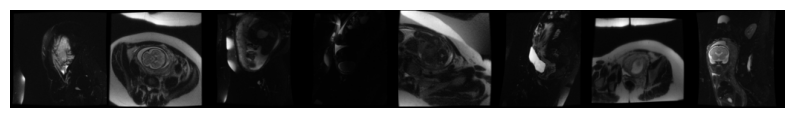

In [6]:
# Define dataset transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load dataset from Kaggle directory
dataset_path = "/content/data/images"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

print(f"Total images loaded: {len(dataset)}")

# Function to show sample images
def show_sample_images():
    real_batch = next(iter(dataloader))
    images, _ = real_batch
    grid = torchvision.utils.make_grid(images[:16], normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.show()

show_sample_images()


In [7]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

G = Generator().to(device)
print(G)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )

    def forward(self, img):
        return self.model(img).view(-1)

D = Discriminator().to(device)
print(D)


Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d

In [8]:
# Compute Gradient Penalty for WGAN-GP
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), device=device)

    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

Epoch [1/500] | D Loss: -0.4035 | G Loss: 2.5544
Epoch [2/500] | D Loss: -2.4866 | G Loss: 2.6157
Epoch [3/500] | D Loss: 0.0234 | G Loss: 3.0186
Epoch [4/500] | D Loss: -0.8143 | G Loss: 3.8665
Epoch [5/500] | D Loss: 0.0830 | G Loss: 4.3488
Epoch [6/500] | D Loss: -0.6952 | G Loss: 3.8015
Epoch [7/500] | D Loss: 0.2502 | G Loss: 4.5838
Epoch [8/500] | D Loss: -0.4970 | G Loss: 4.0677
Epoch [9/500] | D Loss: -0.5916 | G Loss: 3.0830
Epoch [10/500] | D Loss: -0.4887 | G Loss: 3.4586


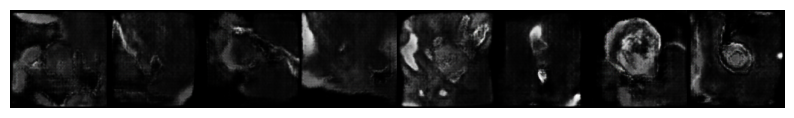

✅ Model and optimizer saved at epoch 10
Epoch [11/500] | D Loss: -0.2088 | G Loss: 3.6038
Epoch [12/500] | D Loss: -0.2587 | G Loss: 3.5335
Epoch [13/500] | D Loss: -0.3605 | G Loss: 4.2673
Epoch [14/500] | D Loss: -0.0263 | G Loss: 4.1616
Epoch [15/500] | D Loss: -0.3128 | G Loss: 3.9106
Epoch [16/500] | D Loss: -0.4370 | G Loss: 5.0430
Epoch [17/500] | D Loss: -0.2164 | G Loss: 4.7972
Epoch [18/500] | D Loss: -0.2111 | G Loss: 5.2873
Epoch [19/500] | D Loss: -0.6027 | G Loss: 6.1235
Epoch [20/500] | D Loss: -0.1812 | G Loss: 5.9804


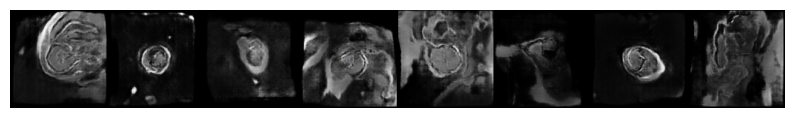

✅ Model and optimizer saved at epoch 20
Epoch [21/500] | D Loss: -0.1985 | G Loss: 6.1729
Epoch [22/500] | D Loss: -0.1725 | G Loss: 6.0538
Epoch [23/500] | D Loss: -0.0388 | G Loss: 6.8296
Epoch [24/500] | D Loss: -0.2541 | G Loss: 6.6274
Epoch [25/500] | D Loss: -0.2705 | G Loss: 7.2568
Epoch [26/500] | D Loss: 0.0993 | G Loss: 6.5131
Epoch [27/500] | D Loss: 0.4683 | G Loss: 7.0305
Epoch [28/500] | D Loss: -0.1916 | G Loss: 7.1249


In [ ]:
import torch
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Hyperparameters
z_dim = 100
epochs = 500
batch_size = 8
lambda_gp = 10
critic_iterations = 5
learning_rate = 0.0001

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.9))

def save_and_display(epoch, gen_imgs):
    """Saves model, optimizer states, and generated images every 10 epochs."""
    # Save generated images
    image_path = f"generated_images/epoch_{epoch+1}.png"
    save_image(gen_imgs, image_path, normalize=True)

    # Display images
    grid = torchvision.utils.make_grid(gen_imgs[:16], normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.show()

    # Save model and optimizer states
    model_path = f"saved_models/epoch_{epoch+1}.pth"
    torch.save({
        'epoch': epoch + 1,
        'generator_state_dict': G.state_dict(),
        'discriminator_state_dict': D.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'loss_G': loss_G.item(),
        'loss_D': loss_D.item(),
    }, model_path)

    print(f"✅ Model and optimizer saved at epoch {epoch+1}")

# Training Loop
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(real_imgs.shape[0], z_dim, 1, 1, device=device)
        fake_imgs = G(z).detach()
        real_loss = D(real_imgs).mean()
        fake_loss = D(fake_imgs).mean()
        gradient_penalty = compute_gradient_penalty(D, real_imgs, fake_imgs)
        loss_D = fake_loss - real_loss + lambda_gp * gradient_penalty
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        if i % critic_iterations == 0:
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            gen_imgs = G(z)
            loss_G = -D(gen_imgs).mean()
            loss_G.backward()
            optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    # Save and Display Every 10 Epochs
    if (epoch + 1) % 10 == 0:
        save_and_display(epoch, gen_imgs)
